In [2]:
# Create the folder for storing the model file
import os

# Folder path where model will be saved
mpi_folder = 'pose/mpi/'
os.makedirs(mpi_folder, exist_ok=True)

# Download the model using wget (from within Jupyter)
# Download the model using curl (Windows alternative to wget)
!curl -L https://www.dropbox.com/s/drumc6dzllfed16/pose_iter_160000.caffemodel?dl=1 -o pose/mpi/pose_iter_160000.caffemodel

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   144  100   144    0     0    197      0 --:--:-- --:--:-- --:--:--   197

100    17  100    17    0     0     12      0  0:00:01  0:00:01 --:--:--    12

  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100   496    0   496    0     0    191      0 --:--:--  0:00:02 --:--:--   396
100   496    0   496    0     0    191      0 --:--:--  0:00:02 --:--:--   396

  0     0    0     0    0     0      0      0 --:--:--  0:00:03 --:--:--     0
  3  196M    3 7440k    0     0  1715k      0  0:01:57  0:00:04  0:01:53 8043k
  9  196M    9 19.6M    0     0  3719k      0  0:00:54  0:00:05  0:00:49  9.8M
 15  196M   15 30.0M    0     0  4803k      0  0

In [7]:
# Import necessary libraries
import os
import cv2
import numpy as np
from glob import glob
from datetime import datetime

# Specify the local dataset path (update this to your dataset's location)
base_dir = "C:/Users/Sudik/Desktop/Sudiksha/btech project/dataCopy"

# List class folders containing the images
classes = ["downdog", "plank", "warrior"]

# Construct the full paths for each class
class_paths = {cls: glob(os.path.join(base_dir, cls, "*")) for cls in classes}

# OpenPose MPII model files
protoFile = "C:/Users/Sudik/Downloads/pose_deploy_linevec_faster_4_stages.prototxt"  # Make sure to have this file in your directory
weightsFile = "pose/mpi/pose_iter_160000.caffemodel"  # Path to the downloaded model

# Load the OpenPose MPII model
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

# Total keypoints
nPoints = 15

# Sensible connections of keypoints forming body parts
POSE_PAIRS = [
    [0, 1], [1, 2], [2, 3], [3, 4], [1, 5], [5, 6], [6, 7], [1, 14], 
    [14, 8], [8, 9], [9, 10], [14, 11], [11, 12], [12, 13]
]

# Keypoint classification probability threshold
threshold = 0.1

# Load OpenPose MPII model
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

# Image dimensions for the network
inWidth = 368
inHeight = 368

# Directory to save processed images
output_dir = os.path.join(base_dir, "processed")
os.makedirs(output_dir, exist_ok=True)

# Start processing
startTime = datetime.now()
n = 0

for pose_class, image_paths in class_paths.items():
    # Create a subdirectory for each class in the output folder
    class_output_dir = os.path.join(output_dir, pose_class)
    os.makedirs(class_output_dir, exist_ok=True)
    
    for pic in image_paths:  # Loop through all images in the class folder
        frame = cv2.imread(pic)  # Load the image
        frameHeight, frameWidth = frame.shape[:2]
        
        # Create a blank white image of the same dimensions
        img = np.zeros([frameHeight, frameWidth, 3], dtype=np.uint8)
        img.fill(255)
        
        # Prepare the image for input to the MPII model
        inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                                        (0, 0, 0), swapRB=False, crop=False)
        net.setInput(inpBlob)  # Set input to the network
        output = net.forward()  # Get the output
        
        # Height, width of the output
        H, W = output.shape[2], output.shape[3]

        # Empty list to store detected keypoints
        points = []

        for i in range(nPoints):
            # Confidence map of corresponding body's part
            probMap = output[0, i, :, :]
            
            # Find global maxima of the probMap
            _, prob, _, point = cv2.minMaxLoc(probMap)
            
            # Scale the point to fit on the original image
            x = (frameWidth * point[0]) / W
            y = (frameHeight * point[1]) / H
            
            if prob > threshold:
                # Append point to the list if the probability > threshold
                points.append((int(x), int(y)))
            else:
                points.append(None)
        
        if points[14]:  # Check if chest keypoint is detected
            # Get the image center point
            center = (frameWidth // 2, frameHeight // 2)
            
            # Calculate shift to align body center with image center
            shift = np.subtract(points[14], center)
            
            newPoints = [(0, 0) for _ in range(len(points))]
            for i in range(len(points)):
                if points[i]:
                    newPoints[i] = tuple(np.subtract(points[i], shift))
                else:
                    newPoints[i] = None
            
            # Plot the skeleton on the blank white image
            for pair in POSE_PAIRS:
                partA = pair[0]
                partB = pair[1]
                if newPoints[partA] and newPoints[partB]:
                    cv2.line(img, newPoints[partA], newPoints[partB], (0, 0, 0), 2)
            
            # Save processed image
            save_path = os.path.join(class_output_dir, f"{pose_class}_{n+1}.jpg")
            cv2.imwrite(save_path, img)
            n += 1

print("Processing complete!")
print("Total images processed:", n)
print("Time taken:", datetime.now() - startTime)

Processing complete!
Total images processed: 31
Time taken: 0:01:10.711435


Classes found: ['C:/Users/Sudik/Desktop/Sudiksha/btech project/data/DATASET/TRAIN\\downdog', 'C:/Users/Sudik/Desktop/Sudiksha/btech project/data/DATASET/TRAIN\\plank', 'C:/Users/Sudik/Desktop/Sudiksha/btech project/data/DATASET/TRAIN\\warrior']
Number of classes: 3
Found 741 images belonging to 3 classes.
Found 321 images belonging to 3 classes.
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 125s 5s/step - accuracy: 0.4854 - loss: 1.2298 - val_accuracy: 0.9533 - val_loss: 0.1514
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 144s 6s/step - accuracy: 0.8851 - loss: 0.2972 - val_accuracy: 0.9907 - val_loss: 0.0631
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 117s 5s/step - accuracy: 0.9337 - loss: 0.2190 - val_accuracy: 0.9875 - val_loss: 0.0518
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 115s 5s/step - accuracy: 0.9617 - loss: 0.1398 - val_accuracy: 0.9813 - val_loss: 0.0491
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 121s 5s/step - accuracy: 0.9663 - loss: 0.1234 - val_accuracy: 0.9875 - val_loss: 0.0539


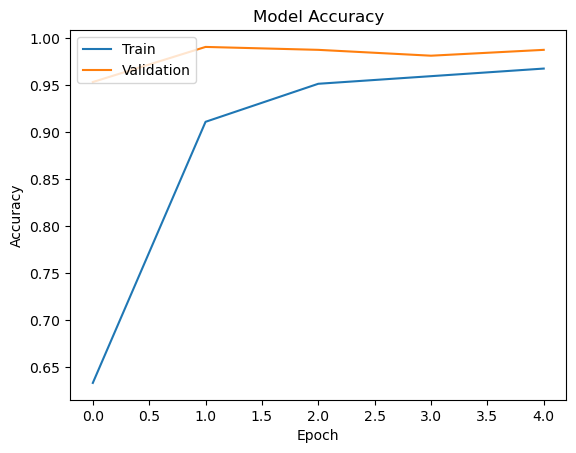

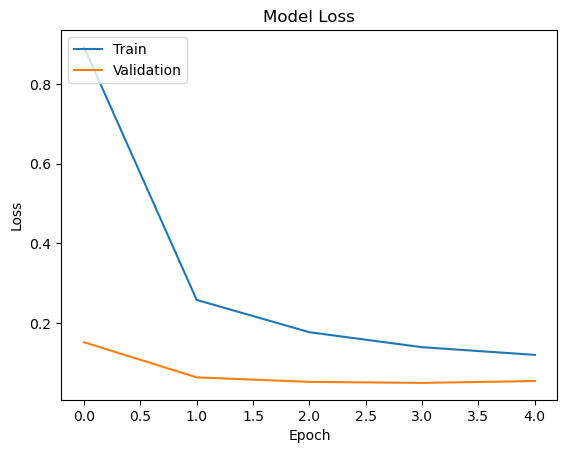

Model saved at C:/Users/Sudik/Desktop/Sudiksha/btech project/model.keras


In [10]:
import cv2
import numpy as np
import pandas as pd
from glob import glob
from datetime import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

import warnings

# To suppress specific warnings
warnings.filterwarnings("ignore", message="Your `PyDataset` class should call")
warnings.filterwarnings("ignore", message="Palette images with Transparency")

img_size = [200, 200]

# Set the directories where train and test data are stored
train_data = "C:/Users/Sudik/Desktop/Sudiksha/btech project/data/DATASET/TRAIN"  # Replace with the actual path to your training data
valid_data = "C:/Users/Sudik/Desktop/Sudiksha/btech project/data/DATASET/TEST"  # Replace with the actual path to your test data

# Fetching classes (folders in the training data directory)
num_classes = glob(train_data + '/*')
print("Classes found:", num_classes)
print("Number of classes:", len(num_classes))

# Data augmentation for increasing the training dataset
train_gen = ImageDataGenerator(rescale=1./255,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True)

# Test data shouldn't be augmented
test_gen = ImageDataGenerator(rescale=1./255)

# Loading the training and testing data
train_set = train_gen.flow_from_directory(train_data,
                                          target_size=(200, 200),
                                          batch_size=32,
                                          class_mode='categorical')

test_set = test_gen.flow_from_directory(valid_data,
                                         target_size=(200, 200),
                                         batch_size=32,
                                         class_mode='categorical')

# Using VGG16 model
vgg16 = VGG16(input_shape=img_size + [3], weights='imagenet', include_top=False)

# We don't want to retrain existing weights
for layer in vgg16.layers:
    layer.trainable = False

# Adding layers
x = Flatten()(vgg16.output)
y = Dense(len(num_classes), activation='softmax')(x)

# Creating model object
model = Model(inputs=vgg16.input, outputs=y)

# Compiling the model with categorical cross entropy for multiclass classification
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Fitting the model
hist = model.fit(train_set, validation_data=test_set, epochs=5)

# It took 55 mins for fitting the model first time on 5 epochs, which achieved 90% accuracy

# Plotting accuracy results
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summarized history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Saving the model locally
model_save_path = "C:/Users/Sudik/Desktop/Sudiksha/btech project/model.keras" # Replace with the actual directory where you want to save the model
model.save(model_save_path)

print(f"Model saved at {model_save_path}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: plank


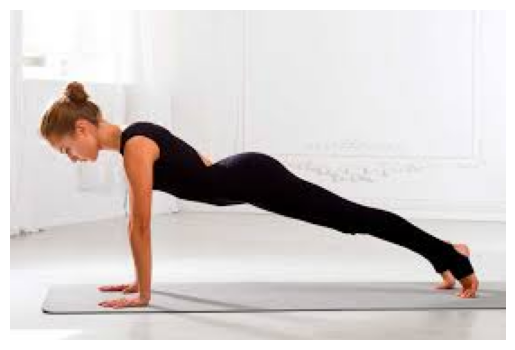

In [14]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the saved model
model = load_model("C:/Users/Sudik/Desktop/Sudiksha/btech project/model.keras")  # Or 'model.h5' if you're using the old format

# Function to preprocess the input image
def preprocess_image(img_path, target_size=(200, 200)):
    # Load the image
    img = image.load_img(img_path, target_size=target_size)
    # Convert the image to an array
    img_array = image.img_to_array(img)
    # Rescale the image (same preprocessing as in training)
    img_array = img_array / 255.0
    # Add an extra dimension to match the model's input shape
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to predict the image class
def predict_image(img_path):
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)
    # Get the predicted class label
    predicted_class = np.argmax(prediction, axis=1)
    return predicted_class

# Input image path (replace this with your image path)
img_path = "C:/Users/Sudik/Downloads/images (5).jpg"

# Predict the image
predicted_class = predict_image(img_path)

# Print the predicted class (you can map it to your actual class names)
class_names = ['downdog', 'plank', 'warrior']  # Replace with your class names
print(f"Predicted Class: {class_names[predicted_class[0]]}")

# Display the image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for proper display
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()